# Swing Trading Strategy Based on Price Action / Multi-Timeframe Strategy

TimeFrames:
1) Weekly - for Marking Breakout Zones
2) Daily - for Stock Selection
3) 15 min - for entry

Strategy working:
1) On weekends, mark previous weeks High and Low on weekly chart
2) For Stock Selection, the stock should have crossed the High/Low and should have closed within High/low in daily chart.
3) In 15 min chart, mark the Highest-high above or below weekly high/low line for stoploss. For entry, mark the nearest lowest-low for the weekly High/low.
4) Target is the weekly High/low line. But you can also book profit after acheiving 1:1 risk:reward


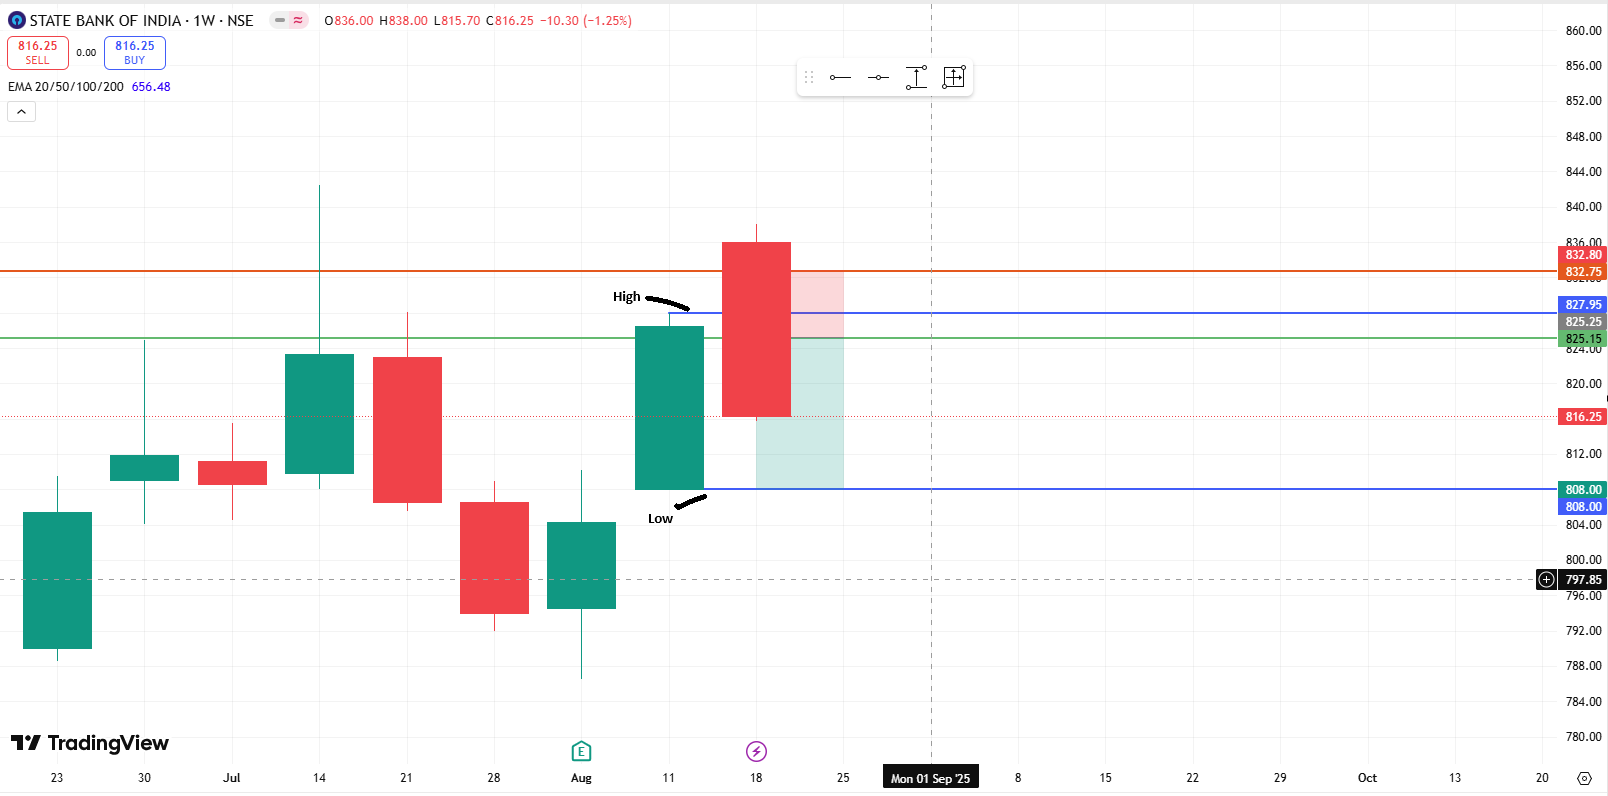

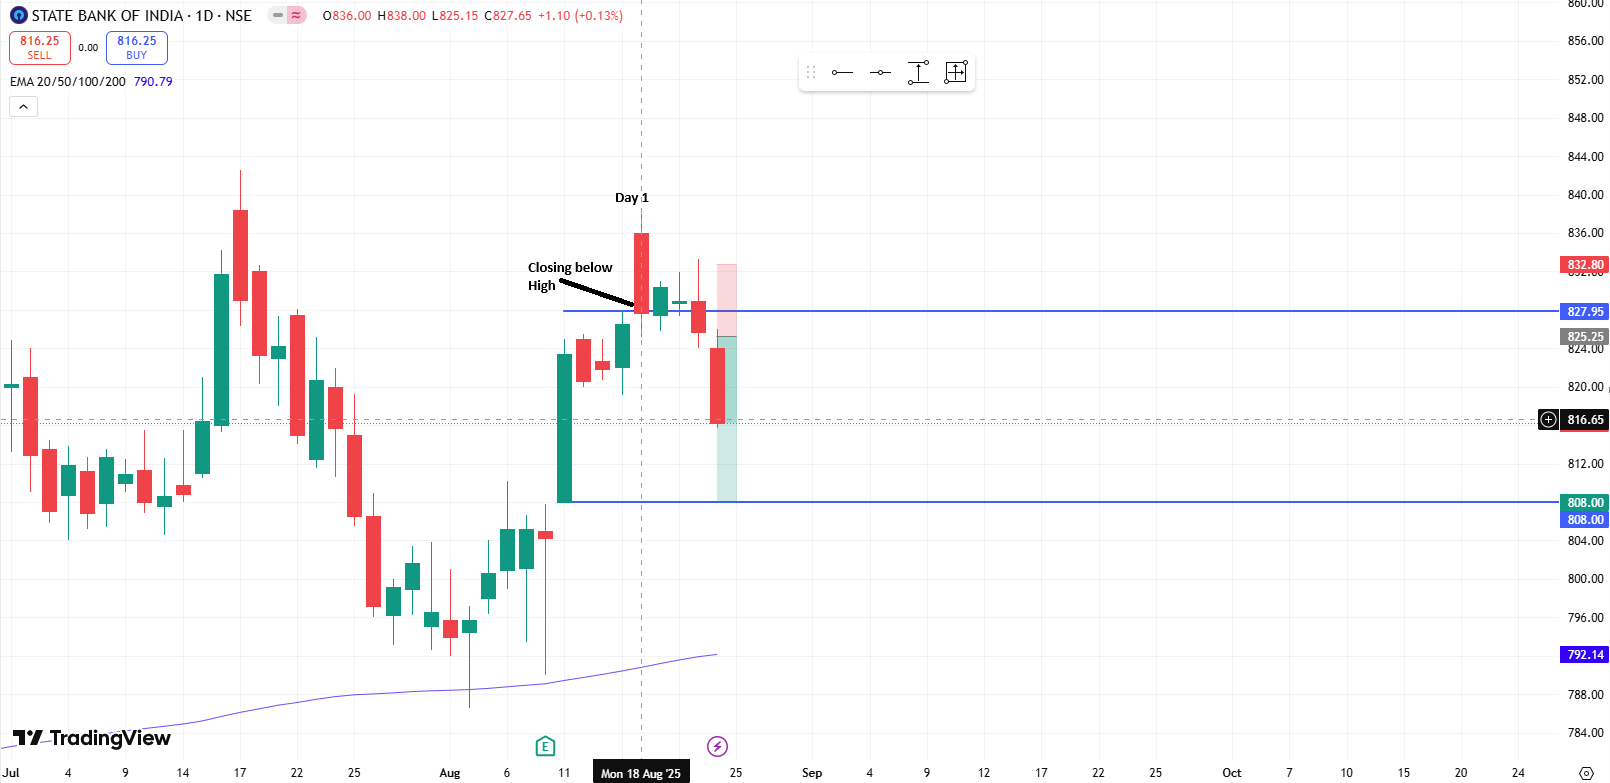

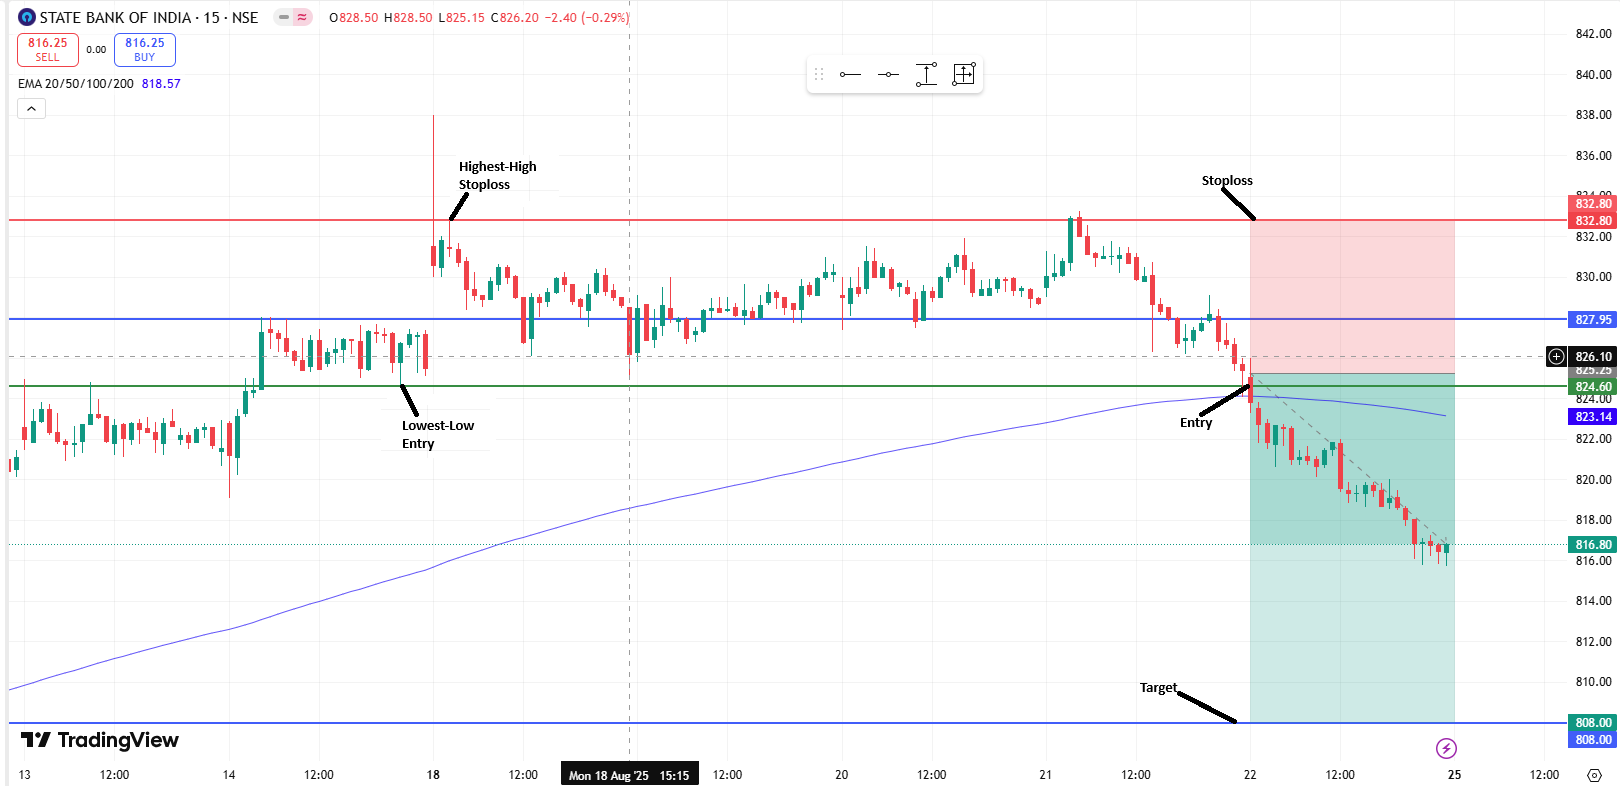

In [27]:
# The below code is for Stock Selection

import pandas as pd
from fyers_apiv3 import fyersModel
import pytz
import datetime as dt
from datetime import datetime, timedelta

client_id = open("../client_ID.txt",'r').read()
access_token = open("../access_token.txt",'r').read()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="D:\FyiersApiAutomation\logs")

def fetchOHLC2(ticker,timeframe='D',lookback=7):
    range_from = dt.date.today() - dt.timedelta(lookback)
    range_to = dt.date.today()

    from_date_string = range_from.strftime("%Y-%m-%d")
    to_date_string = range_to.strftime("%Y-%m-%d")

    data = {
        "symbol":ticker,
        "resolution":timeframe,
        "date_format":"1",
        "range_from":from_date_string,
        "range_to":to_date_string,
        "cont_flag":"1"
    }
    
    response = fyers.history(data=data)['candles']

    # Create a Dataframe
    columns = ['Timestamp','Open','High','Low','Close','Volume']
    df = pd.DataFrame(response, columns=columns)

    # Convert Timestamp to datetime in UTC
    df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.tz_localize(pytz.utc)

    # Convert Timestamp to IST
    ist = pytz.timezone('Asia/Kolkata')
    df['Date'] = df['Date'].dt.tz_convert(ist)
    df = df.drop(columns=['Timestamp'])
    
    return df[['Date', 'Open', 'High', 'Low', 'Close']]



In [67]:
def fetch_candle_data(symbol,timeframe,lookback=None):

    df = fetchOHLC2(symbol, lookback=30)  # fetch ~30 days just in case
    df['Date'] = pd.to_datetime(df['Date'])

    if timeframe == "D":
        # Just return last `lookback` daily candles
        print(df.tail(lookback))
        return df.tail(lookback)

    elif timeframe == "W":
        # ---- Step 2: Find last week's Monday-Friday ----
        today = datetime.today()
        last_monday = today - timedelta(days=today.weekday() + 7)
        last_friday = last_monday + timedelta(days=4)

        print("Today: ",today)
        print("last_monday: ",last_monday)
        print("last_friday:", last_friday)

        # ---- Step 3: Filter only last week's data ----
        week_data = df[(df['Date'].dt.date >= last_monday.date()) & 
                    (df['Date'].dt.date <= last_friday.date())]

        print(week_data)

        if week_data.empty:
            return None  # No data available

        # ---- Step 4: Create weekly candle ----
        weekly_candle = pd.DataFrame([{
            'Week': f"{last_monday.date()} → {last_friday.date()}",
            'Open': week_data.iloc[0]['Open'],
            'High': week_data['High'].max(),
            'Low': week_data['Low'].min(),
            'Close': week_data.iloc[-1]['Close'],
        }])

        return weekly_candle

daily_df = fetch_candle_data('NSE:SBIN-EQ', timeframe="D", lookback=7)
print(daily_df)
time.sleep(1)

# Get last week's candle
weekly_df = fetch_candle_data('NSE:SBIN-EQ', timeframe="W")
print(weekly_df)



                        Date    Open    High     Low   Close
13 2025-08-14 05:30:00+05:30  822.00  828.00  819.10  826.55
14 2025-08-18 05:30:00+05:30  836.00  838.00  825.15  827.65
15 2025-08-19 05:30:00+05:30  827.50  831.00  825.80  830.40
16 2025-08-20 05:30:00+05:30  828.70  831.90  827.40  828.95
17 2025-08-21 05:30:00+05:30  828.95  833.25  824.05  825.70
18 2025-08-22 05:30:00+05:30  824.00  826.00  815.70  816.25
19 2025-08-25 05:30:00+05:30  817.45  820.50  814.20  816.45
                        Date    Open    High     Low   Close
13 2025-08-14 05:30:00+05:30  822.00  828.00  819.10  826.55
14 2025-08-18 05:30:00+05:30  836.00  838.00  825.15  827.65
15 2025-08-19 05:30:00+05:30  827.50  831.00  825.80  830.40
16 2025-08-20 05:30:00+05:30  828.70  831.90  827.40  828.95
17 2025-08-21 05:30:00+05:30  828.95  833.25  824.05  825.70
18 2025-08-22 05:30:00+05:30  824.00  826.00  815.70  816.25
19 2025-08-25 05:30:00+05:30  817.45  820.50  814.20  816.45
Today:  2025-08-25 20:42

In [61]:
# Code for Stock Selection

# day_df = fetchOHLC2("NSE:AXISBANK-EQ","D",1)
# print(day_df)

def stock_selection(symbol, day_df, week_high, week_low):

    last_day = day_df.iloc[-1]
    signal_in_stock = []

    if last_day['Close'] > week_low or last_day['Close'] < week_high:
        if last_day['Open'] < week_low or last_day['Low'] < week_low:
            print(f"{symbol} found breaking weekly Low")
            signal_in_stock.append("Signal Generated by breaking week low")

        elif last_day['Open'] > week_high or last_day['High'] > week_high:
                print(f"{symbol} found breaking weekly High")
                signal_in_stock.append("Signal Generated by breaking week high")
                
        else:
            print("No Stock found breaking weekly Low/High")
            signal_in_stock.append("NA")

    return signal_in_stock

# day_df = fetchOHLC2('NSE:AXISBANK-EQ',"D",1)
# stock_sel = stock_selection('NSE:AXISBANK-EQ',day_df,1505.0,1458.0)
# print(stock_sel)


                       Date  Open    High     Low  Close
0 2025-08-25 05:30:00+05:30  1073  1074.5  1068.2   1070
NSE:AXISBANK-EQ found breaking weekly Low
['Signal Generated by breaking week low']


In [64]:
import datetime as dt
import time
def run_scanner(symbols):
    results = []
    
    for symbol in symbols:
        # Get last 7 daily candles
        daily_df = fetch_candle_data(symbol, timeframe="D", lookback=7)

        time.sleep(1)

        # Get last week's candle
        weekly_df = fetch_candle_data(symbol, timeframe="W")

        time.sleep(1)

        week_high = weekly_df.at[weekly_df.index[0],'High']
        week_low = weekly_df.at[weekly_df.index[0],'Low']
        #week_low = weekly_df['Low'].at[-1]
        
        day_df = fetchOHLC2(symbol,"D",1)
        last_day_close = day_df['Close'].iloc[-1]
        signals = stock_selection(symbol,day_df,week_high,week_low)

        counter = 0
        time.sleep(1)
        results.append({
            "Symbol": symbol,
            "Weekly_High": week_high,
            "Weekly_Low": week_low,
            "Prev_day_close": last_day_close,
            "Signal": signals[counter]
        })
        counter = counter + 1
    return results

    
    #print(uptrend_filtered_data)
    # result_df = pd.DataFrame(results)
    # for col in ["Signal_date","Buy_price","Stoploss"]:
    #         if col not in result_df.columns:
    #             result_df[col] = [[] for _ in range(len(result_df))]
    
    # result_df = result_df.explode(["Signal_date","Buy_price","Stoploss"],ignore_index=True)

In [63]:
symbols = [
'NSE:ABB-EQ',
'NSE:ADANIENSOL-EQ',
'NSE:ADANIENT-EQ',
'NSE:ADANIGREEN-EQ',
'NSE:ADANIPORTS-EQ',
'NSE:ADANIPOWER-EQ',
'NSE:AMBUJACEM-EQ',
'NSE:APOLLOHOSP-EQ',
'NSE:ASIANPAINT-EQ',
'NSE:DMART-EQ',
'NSE:AXISBANK-EQ',
'NSE:BAJAJ-AUTO-EQ',
'NSE:BAJFINANCE-EQ',
'NSE:BAJAJFINSV-EQ',
'NSE:BAJAJHLDNG-EQ',
'NSE:BAJAJHFL-EQ',
'NSE:BANKBARODA-EQ',
'NSE:BEL-EQ',
'NSE:BPCL-EQ',
'NSE:BHARTIARTL-EQ',
'NSE:BOSCHLTD-EQ',
'NSE:BRITANNIA-EQ',
'NSE:CGPOWER-EQ',
'NSE:CANBK-EQ',
'NSE:CHOLAFIN-EQ',
'NSE:CIPLA-EQ',
'NSE:COALINDIA-EQ',
'NSE:DLF-EQ',
'NSE:DABUR-EQ',
'NSE:DIVISLAB-EQ',
'NSE:DRREDDY-EQ',
'NSE:EICHERMOT-EQ',
'NSE:ETERNAL-EQ',
'NSE:GAIL-EQ',
'NSE:GODREJCP-EQ',
'NSE:GRASIM-EQ',
'NSE:HCLTECH-EQ',
'NSE:HDFCBANK-EQ',
'NSE:HDFCLIFE-EQ',
'NSE:HAVELLS-EQ',
'NSE:HEROMOTOCO-EQ',
'NSE:HINDALCO-EQ',
'NSE:HAL-EQ',
'NSE:HINDUNILVR-EQ',
'NSE:HYUNDAI-EQ',
'NSE:ICICIBANK-EQ',
'NSE:ICICIGI-EQ',
'NSE:ICICIPRULI-EQ',
'NSE:ITC-EQ',
'NSE:INDHOTEL-EQ',
'NSE:IOC-EQ',
'NSE:IRFC-EQ',
'NSE:INDUSINDBK-EQ',
'NSE:NAUKRI-EQ',
'NSE:INFY-EQ',
'NSE:INDIGO-EQ',
'NSE:JSWENERGY-EQ',
'NSE:JSWSTEEL-EQ',
'NSE:JINDALSTEL-EQ',
'NSE:JIOFIN-EQ',
'NSE:KOTAKBANK-EQ',
'NSE:LTIM-EQ',
'NSE:LT-EQ',
'NSE:LICI-EQ',
'NSE:LODHA-EQ',
'NSE:M&M-EQ',
'NSE:MARUTI-EQ',
'NSE:NTPC-EQ',
'NSE:NESTLEIND-EQ',
'NSE:ONGC-EQ',
'NSE:PIDILITIND-EQ',
'NSE:PFC-EQ',
'NSE:POWERGRID-EQ',
'NSE:PNB-EQ',
'NSE:RECLTD-EQ',
'NSE:RELIANCE-EQ',
'NSE:SBILIFE-EQ',
'NSE:MOTHERSON-EQ',
'NSE:SHREECEM-EQ',
'NSE:SHRIRAMFIN-EQ',
'NSE:SIEMENS-EQ',
'NSE:SBIN-EQ',
'NSE:SUNPHARMA-EQ',
'NSE:SWIGGY-EQ',
'NSE:TVSMOTOR-EQ',
'NSE:TCS-EQ',
'NSE:TATACONSUM-EQ',
'NSE:TATAMOTORS-EQ',
'NSE:TATAPOWER-EQ',
'NSE:TATASTEEL-EQ',
'NSE:TECHM-EQ',
'NSE:TITAN-EQ',
'NSE:TORNTPHARM-EQ',
'NSE:TRENT-EQ',
'NSE:ULTRACEMCO-EQ',
'NSE:UNITDSPR-EQ',
'NSE:VBL-EQ',
'NSE:VEDL-EQ',
'NSE:WIPRO-EQ',
'NSE:ZYDUSLIFE-EQ',
]

print("Generating Signals...")
signals_df = run_scanner(symbols)
print(signals_df)

strategy_signals = pd.DataFrame(signals_df,columns=['Symbol','Weekly_High','Weekly_Low','Prev_day_close','Signal'])
swing_price_action = strategy_signals.to_csv("swing_price_action_output.csv")



Generating Signals...
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
NSE:ASIANPAINT-EQ found breaking weekly Low
No Stock found breaking weekly Low/High
NSE:AXISBANK-EQ found breaking weekly Low
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
NSE:BAJAJHLDNG-EQ found breaking weekly Low
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
No Stock found breaking weekly Low/High
NSE:CANBK-EQ found breaking weekly Low
No Stock 